In [57]:
import collections

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
raw_log_path = './dataset/data/log_standard_4_08_to_4_21_pure.csv'
user_feature_path = './dataset/data/user_features_pure.csv'
video_feature_path = './dataset/data/video_features_basic_pure.csv'
save_path = './dataset/data/save/'
category_features = (['user_id', 'weekday', 'hourmin', 'user_active_degree', 'is_video_author',
                     'follow_user_num_range', 'fans_user_num_range', 'friend_user_num_range', 'register_days_range']
                     + [f'onehot_feat{i}' for i in range(18)]
                     + ['video_id', 'author_id', 'upload_type', 'tag'])
continuous_features = ['duration_ms', 'server_width', 'server_height', 'follow_user_num', 'fans_user_num', 'friend_user_num']
labels = ['effective_view', 'is_like', 'long_view', 'is_follow', 'is_comment', 'is_forward']# , 'is_not_hate']
history_length_max_per_user = 20
history_length_min_per_user = 3
history_id_columns = [f'history_id_{i}' for i in range(1, history_length_max_per_user + 1)]
history_tag_columns = [f'history_tag_{i}' for i in range(1, history_length_max_per_user + 1)]
emp_list = ['emp_'+label for label in labels]
gen_columns = history_tag_columns + history_id_columns + emp_list + ['curr_len']
user_features = (['user_id', 'weekday', 'hourmin', 'user_active_degree', 'is_video_author',
                     'follow_user_num_range', 'fans_user_num_range', 'friend_user_num_range', 'register_days_range', 'follow_user_num', 'fans_user_num', 'friend_user_num'] +
                [f'onehot_feat{i}' for i in range(18)]) + history_tag_columns + history_id_columns


In [24]:
test_aux_df = pd.read_csv('./data/save/test_predict_data_mmoeaux.csv')
test_aux_df.columns = category_features + continuous_features + gen_columns + labels + ['p_'+l for l in labels] + ['w_'+l for l in labels]
for col in category_features:
    test_aux_df[col] = test_aux_df[col].map(int)
test_aux_df.head(20)

,user_id,weekday,hourmin,user_active_degree,is_video_author,follow_user_num_range,fans_user_num_range,friend_user_num_range,register_days_range,onehot_feat0,...,p_long_view,p_is_follow,p_is_comment,p_is_forward,w_effective_view,w_is_like,w_long_view,w_is_follow,w_is_comment,w_is_forward
0,27275,3,17,4,1,7,2,5,5,1,...,0.331858,0.000533,0.000808,0.000326,0.430705,1.000000,0.434008,1.000000,1.000000,1.000000
1,22650,3,17,4,1,4,2,5,5,0,...,0.249902,0.000047,0.000138,0.000045,0.430705,1.000000,0.434008,1.000000,0.998282,1.000000
2,15383,3,17,7,1,4,1,0,5,1,...,0.913792,0.002848,0.004871,0.003326,1.000000,0.557877,1.000000,1.000000,1.000000,1.000000
3,11988,3,17,4,1,1,1,2,6,1,...,0.596418,0.000643,0.002647,0.000579,0.999915,1.000000,1.000000,1.000000,1.000000,1.000000
4,19898,3,17,4,1,3,3,6,5,0,...,0.598933,0.000095,0.000411,0.000131,0.492412,1.000000,0.489328,1.000000,0.188832,1.000000
5,8795,3,17,4,1,1,3,5,5,0,...,0.122511,0.000042,0.000138,0.000039,0.430705,1.000000,0.434008,0.962020,1.000000,1.000000
6,17581,3,17,5,1,7,6,1,1,0,...,0.818348,0.002497,0.008099,0.001663,0.430710,0.354824,0.501742,1.000000,1.000000,0.999960
7,18191,3,17,5,1,3,3,3,5,1,...,0.677097,0.000492,0.001210,0.000593,0.494290,1.000000,0.498268,1.000000,1.000000,1.000000
8,5305,3,17,4,1,4,3,3,3,0,...,0.074175,0.000216,0.000645,0.000059,1.000000,1.000000,1.000000,0.999802,1.000000,1.000000
9,14619,3,17,7,1,4,3,1,3,1,...,0.588013,0.000123,0.000252,0.000063,0.492416,1.000000,0.489328,1.000000,1.000000,1.000000


In [59]:
record_weight = collections.defaultdict(list)
for label in labels:
    # print(test_aux_df['emp_' + label].quantile(0.8))
    # print(test_aux_df['emp_' + label].quantile(0.2))
    record_weight['pos_high'].append(test_aux_df[(test_aux_df['emp_' + label] > test_aux_df['emp_' + label].quantile(0.9)) & (test_aux_df[label] == 1)]['w_' + label].mean())
    record_weight['neg_high'].append(test_aux_df[(test_aux_df['emp_' + label] > test_aux_df['emp_' + label].quantile(0.9)) & (test_aux_df[label] == 0)]['w_' + label].mean())
    record_weight['pos_low'].append(test_aux_df[(test_aux_df['emp_' + label] <= test_aux_df['emp_' + label].quantile(0.4)) & (test_aux_df[label] == 1)]['w_' + label].mean())
    record_weight['neg_low'].append(test_aux_df[(test_aux_df['emp_' + label] <= test_aux_df['emp_' + label].quantile(0.4)) & (test_aux_df[label] == 0)]['w_' + label].mean())
    # print('正样本高'+label, pos_high_weight)
    # print('负样本高'+label, neg_high_weight)
    # print('正样本低'+label, pos_low_weight)
    # print('负样本低'+label, neg_low_weight)
    # print()

   pos_high  neg_high   pos_low   neg_low
0  0.598824  0.898799  0.825052  0.656748
1  0.565845  0.987674  0.951269  0.580070
2  0.584924  0.913034  0.818894  0.670539
3  0.663790  0.983766  0.903080  0.753633
4  0.751237  0.993735  0.910032  0.674433
5  0.676165  0.996400  0.970873  0.677514


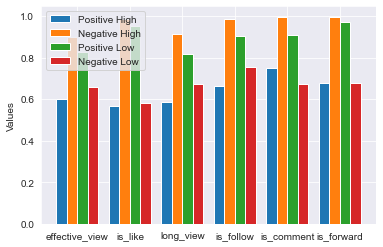

In [64]:
import matplotlib.pyplot as plt
import numpy as np

# 数据
record_weight = {'pos_high': [0.5988236920422424, 0.5658447387770479, 0.5849236893580934, 0.6637900188565254, 0.7512371900180975, 0.6761645831559834], 'neg_high': [0.8987989552567498, 0.9876744009719732, 0.9130337594524389, 0.9837659867997476, 0.993734952849787, 0.9963999386318028], 'pos_low': [0.8250515630195567, 0.9512688533123661, 0.8188941978329657, 0.9030802881280386, 0.9100322628574298, 0.9708731171026612], 'neg_low': [0.6567476225642127, 0.5800700295356012, 0.6705386941326175, 0.7536330893194887, 0.6744334491945448, 0.6775144437948862]}
weight_df = pd.DataFrame(record_weight, index=list(range(len(labels))))
print(weight_df)
# types = ['pos_high', 'neg_high', 'pos_low', 'neg_low']
# positive_high, negative_high, positive_low, negative_low = [], [], [], []
positive_high = weight_df['pos_high']
negative_high = weight_df['neg_high']
positive_low = weight_df['pos_low']
negative_low = weight_df['neg_low']

bar_width = 0.2
index = np.arange(len(labels))

# 画簇状柱形图
plt.bar(index - 1.5 * bar_width, positive_high, width=bar_width, label='Positive High')
plt.bar(index - 0.5 * bar_width, negative_high, width=bar_width, label='Negative High')
plt.bar(index + 0.5 * bar_width, positive_low, width=bar_width, label='Positive Low')
plt.bar(index + 1.5 * bar_width, negative_low, width=bar_width, label='Negative Low')

# 设置图例
plt.legend()

# 设置横坐标和纵坐标的标签
plt.xticks(index, labels)
plt.ylabel('Values')

# 显示图形
# plt.show()
plt.savefig('./data/figure/weight.png')